In [23]:
!pip install snowflake-connector-python

In [24]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import plotly as py

%matplotlib inline
warnings.filterwarnings("ignore")

import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

import os
import snowflake.connector

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import FunctionTransformer

from datetime import datetime, timedelta

In [25]:
# Snowflake credentials
username = 'Harshiteggoz'
password = 'Eggoz@123'
account = 'wt08714.ap-south-1.aws'
warehouse = 'COMPUTE_WH'
database = 'EGGOZDB'
schema = 'MAPLEMONK'

In [26]:
def transform(query):
    # Execute Snowflake SQL Queries
    conn = snowflake.connector.connect(
        user=username,
        password=password,
        account=account,
        warehouse=warehouse,
        database=database,
        schema=schema
    )
    cur = conn.cursor()
    cur.execute(f"USE {database}.{schema}")

    result_df = pd.read_sql_query(query, conn)

    return result_df

In [119]:
query = '''select * from po_data_for_tg'''

data = transform(query)

In [120]:
data['PO_DATE'] = pd.to_datetime(data['PO_DATE'])

start_date = '2022-05-02'
end_date = '2024-05-19'
data = data.loc[(data['PO_DATE'] >= start_date) & (data['PO_DATE'] <= end_date)]

daily_sales = data.groupby(['PO_DATE','CITY_NAME'], as_index=False)['DEMANDED_EGGS'].sum()

city_list = list(set(daily_sales['CITY_NAME'].to_list()))

In [121]:


def spline_transformer(period, degree=3, extrapolation="periodic"):
    """
    Returns a transformer that applies B-spline transformation.
    """
    return SplineTransformer(
                degree=degree,
                n_knots=period+1,
                knots='uniform',
                extrapolation=extrapolation,
                include_bias=True
            ).set_output(transform="pandas")


def sin_transformer(period):
	"""
	Returns a transformer that applies sine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	"""
	Returns a transformer that applies cosine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [122]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['PO_DATE']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['is_weekend'] = df['date'].dt.dayofweek.isin([4, 5, 6]).astype(int)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    df['prev1_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(1)
    df['prev2_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(2)
    df['prev3_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(3)
    df['prev2mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=2, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev3mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=3, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    #df['prev1year_demand'] = df.groupby(['CITY_NAME','weekofyear','dayofweek'])['DEMANDED_EGGS'].shift(1)
    #df['prevweekyear_demanded_mean'] = df.groupby(['CITY_NAME', 'weekofyear', 'year'])['prev1year_demand'].transform('mean')

    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

    df['dayofweek_sin'] = sin_transformer(7).fit_transform(df['dayofweek'])
    df['dayofweek_cos'] = cos_transformer(7).fit_transform(df['dayofweek'])

    df['year_sin'] = sin_transformer(3).fit_transform(df['year'])
    df['year_cos'] = cos_transformer(3).fit_transform(df['year'])


    #splines_dayofyear = spline_transformer(period=12).fit_transform(df[['dayofyear']])
    splines_dayofmonth = spline_transformer(period=4).fit_transform(df[['dayofmonth']])
    splines_weekofyear = spline_transformer(period=12).fit_transform(df[['weekofyear']])

    df = pd.concat([df,
                    #splines_dayofyear,
                    splines_dayofmonth, splines_weekofyear], axis=1)
    #df = pd.get_dummies(df,columns = ['CITY_NAME'], drop_first=False, dtype = 'int')

    return df.drop(['date','month','quarter','dayofweek','year',
                    #'dayofyear',
                    'dayofmonth','weekofyear'], axis=1)

In [123]:
def split_it(df, label=None):

    X = df.drop([label,'PO_DATE'],axis=1)
    if label:
      y = df[label]
      return X,y
    return X

In [124]:
df = create_features(daily_sales).copy()

df = df[df['CITY_NAME']=='Gurgaon'].copy()
df.drop('CITY_NAME',axis=1,inplace=True)

In [125]:
split_date = '2024-05-13'
df_train = df.loc[df.PO_DATE < split_date].copy()
df_test = df.loc[df.PO_DATE >= split_date].copy()

In [126]:
X_train, y_train = split_it(df_train, label='DEMANDED_EGGS')
X_test, y_test = split_it(df_test, label='DEMANDED_EGGS')

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 2 to 2155
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_weekend        293 non-null    int64  
 1   is_month_start    293 non-null    int64  
 2   is_month_end      293 non-null    int64  
 3   season            293 non-null    int8   
 4   prev1_demand      290 non-null    float64
 5   prev2_demand      287 non-null    float64
 6   prev3_demand      284 non-null    float64
 7   prev4_demand      281 non-null    float64
 8   prev5_demand      278 non-null    float64
 9   prev6_demand      275 non-null    float64
 10  prev7_demand      272 non-null    float64
 11  prev2mean_demand  290 non-null    float64
 12  prev3mean_demand  290 non-null    float64
 13  prev4mean_demand  290 non-null    float64
 14  prev5mean_demand  290 non-null    float64
 15  prev6mean_demand  290 non-null    float64
 16  month_sin         293 non-null    float64
 17  m

In [127]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

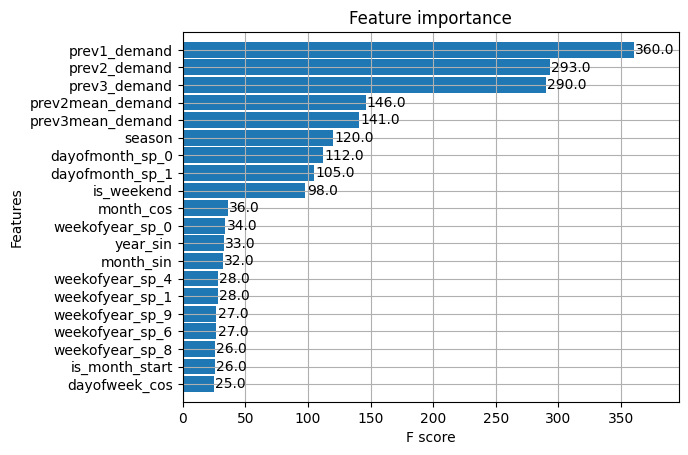

In [128]:
plot_importance(reg, height=0.9, max_num_features = 20)

In [129]:
df_test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [136]:
X_test

,is_weekend,is_month_start,is_month_end,season,prev1_demand,prev2_demand,prev3_demand,prev2mean_demand,prev3mean_demand,month_sin,month_cos,quarter_sin,quarter_cos,dayofweek_sin,dayofweek_cos,year_sin,year_cos,dayofmonth_sp_0,dayofmonth_sp_1,dayofmonth_sp_2,dayofmonth_sp_3,weekofyear_sp_0,weekofyear_sp_1,weekofyear_sp_2,weekofyear_sp_3,weekofyear_sp_4,weekofyear_sp_5,weekofyear_sp_6,weekofyear_sp_7,weekofyear_sp_8,weekofyear_sp_9,weekofyear_sp_10,weekofyear_sp_11
2165,0,0,0,1,41424.0,32042.0,49028.0,36733.0,40831.333333,0.5,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-0.866025,-0.5,0.036000,0.010667,0.414667,0.538667,0.0,0.0,0.0,0.0,0.02473,0.49732,0.460581,0.017369,0.0,0.0,0.0,0.0
2176,0,0,0,1,30994.0,29992.0,53705.0,30493.0,38230.333333,0.5,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-0.866025,-0.5,0.108494,0.000395,0.241037,0.650074,0.0,0.0,0.0,0.0,0.02473,0.49732,0.460581,0.017369,0.0,0.0,0.0,0.0
2183,1,0,0,1,53850.0,55464.0,63590.0,54657.0,57634.666667,0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,-0.866025,-0.5,0.241037,0.000395,0.108494,0.650074,0.0,0.0,0.0,0.0,0.02473,0.49732,0.460581,0.017369,0.0,0.0,0.0,0.0


<Axes: >

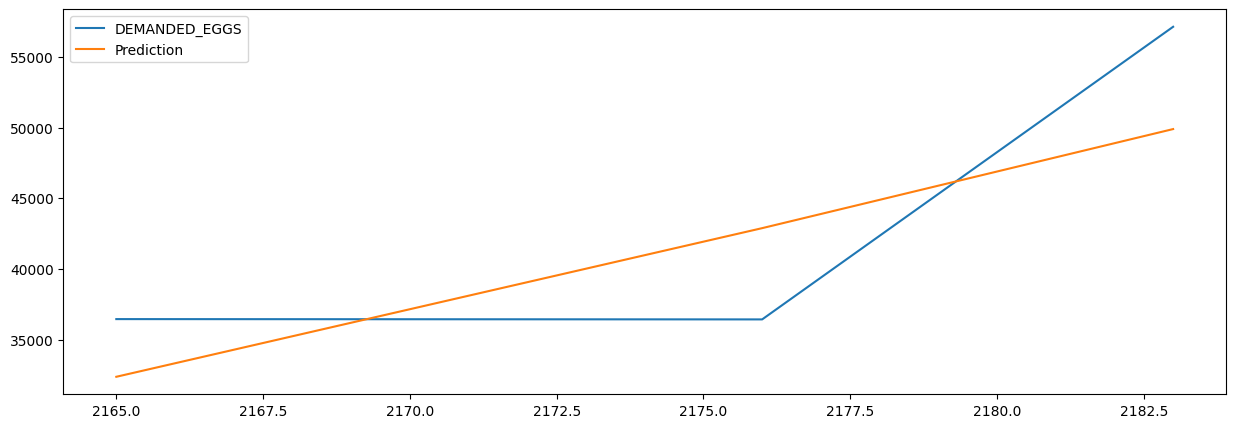

In [130]:
df_all.loc[df_all.PO_DATE>=split_date][['DEMANDED_EGGS','Prediction']].plot(figsize=(15, 5))

In [131]:
mean_squared_error(y_true=df_test['DEMANDED_EGGS'],
                   y_pred=df_test['Prediction'])

36886066.57351303

In [132]:
mean_absolute_error(y_true=df_test['DEMANDED_EGGS'],
                   y_pred=df_test['Prediction'])

5923.272786458333

In [133]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [134]:
mean_absolute_percentage_error(y_true=df_test['DEMANDED_EGGS'],
                   y_pred=df_test['Prediction'])

13.858481488983063

In [145]:
#df_all.loc[df_all.PO_DATE>='2024-05-13'][['CITY_NAME','DEMANDED_EGGS','Prediction']].groupby(['CITY_NAME']).sum()

df_all.loc[df_all.PO_DATE>='2024-05-13'][['DEMANDED_EGGS','Prediction']].sum()

DEMANDED_EGGS    130010.00000
Prediction       125149.78125
dtype: float64

In [ ]:
df_all.loc[df_all.loc[df_all.PO_DATE>='2024-05-13'][['DEMANDED_EGGS','Prediction']].index.to_list()][['PO_DATE','DEMANDED_EGGS','Prediction']]

,PO_DATE,DEMANDED_EGGS,Prediction
2165,2024-05-13,36452.0,27574.115234
2176,2024-05-15,36430.0,30338.898438
2183,2024-05-17,57128.0,45337.097656


In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['PO_DATE']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['is_weekend'] = df['date'].dt.dayofweek.isin([4, 5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.day.isin([1,2,3,4,5,6,7]).astype(int)

    #df['is_month_start'] = df.date.dt.is_month_start.astype(int)

    df['is_month_end'] = df['date'].dt.day.isin([25,26,27,28,29,30,31]).astype(int)
    #df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int")
    #season_dummies = pd.get_dummies(df, columns=['season'], dtype='int', drop_first=True)
    #df = pd.concat([df, season_dummies], axis=1)
    df['prev1_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(1)
    #df['prev1_demand2'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(1)
    df['prev2_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(2)
    #df['prev2_demand2'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(2)
    df['prev3_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(3)
    df['prev4_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(4)
    df['prev5_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(5)
    df['prev6_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(6)
    df['prev7_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(7)
    df['prev2mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=2, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev3mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=3, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev4mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=4, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev5mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=5, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev6mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=6, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    #df['prev2yearmean_demand'] = df.groupby(['CITY_NAME','weekofyear','dayofweek'])['DEMANDED_EGGS'].rolling(window=3, min_periods=1, closed = 'left').mean().reset_index(level=[0,1,2], drop=True)
    #df['prev1year_demand'] = df.groupby(['CITY_NAME','weekofyear','dayofweek'])['DEMANDED_EGGS'].shift(1)
    #df['prevweekyear_demanded_mean'] = df.groupby(['CITY_NAME', 'weekofyear', 'year'])['prev1year_demand'].transform('mean')

    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

    df['dayofweek_sin'] = sin_transformer(7).fit_transform(df['dayofweek'])
    df['dayofweek_cos'] = cos_transformer(7).fit_transform(df['dayofweek'])

    #df['year_sin'] = sin_transformer(3).fit_transform(df['year'])
    #df['year_cos'] = cos_transformer(3).fit_transform(df['year'])


    #splines_dayofyear = spline_transformer(period=12).fit_transform(df[['dayofyear']])
    splines_dayofmonth = spline_transformer(period=4).fit_transform(df[['dayofmonth']])
    splines_weekofyear = spline_transformer(period=12).fit_transform(df[['weekofyear']])

    df = pd.concat([df,
                    #splines_dayofyear,
                    splines_dayofmonth, splines_weekofyear], axis=1)
    #df = pd.get_dummies(df,columns = ['CITY_NAME'], drop_first=False, dtype = 'int')

    return df.drop(['date','month','quarter','dayofweek','year',
                    #'dayofyear',
                    'dayofmonth','weekofyear'], axis=1)

In [181]:
def create_features(df):
  df['date'] = df['PO_DATE']
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  #df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.isocalendar().week
  df['is_weekend'] = df['date'].dt.dayofweek.isin([4, 5, 6]).astype(int)
  df['is_month_start'] = df.date.dt.is_month_start.astype(int)
  df['is_month_end'] = df.date.dt.is_month_end.astype(int)
  df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
  df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
  df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
  df['prev1_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(1)
  df['prev2_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(2)
  df['prev3_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(3)
  df['prev2mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=2, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
  df['prev3mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=3, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
  #df['prev1year_demand'] = df.groupby(['CITY_NAME','weekofyear','dayofweek'])['DEMANDED_EGGS'].shift(1)
  #df['prevweekyear_demanded_mean'] = df.groupby(['CITY_NAME', 'weekofyear', 'year'])['prev1year_demand'].transform('mean')

  df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
  df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

  df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
  df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

  df['dayofweek_sin'] = sin_transformer(7).fit_transform(df['dayofweek'])
  df['dayofweek_cos'] = cos_transformer(7).fit_transform(df['dayofweek'])

  df['year_sin'] = sin_transformer(3).fit_transform(df['year'])
  df['year_cos'] = cos_transformer(3).fit_transform(df['year'])


  #splines_dayofyear = spline_transformer(period=12).fit_transform(df[['dayofyear']])
  splines_dayofmonth = spline_transformer(period=4).fit_transform(df[['dayofmonth']])
  splines_weekofyear = spline_transformer(period=12).fit_transform(df[['weekofyear']])

  df = pd.concat([df,
                  #splines_dayofyear,
                  splines_dayofmonth, splines_weekofyear], axis=1)
  #df = pd.get_dummies(df,columns = ['CITY_NAME'], drop_first=False, dtype = 'int')

  return df.drop(['date','month','quarter','dayofweek','year',
                  #'dayofyear',
                  'dayofmonth','weekofyear'], axis=1)

In [214]:
def spline_transformer(period, degree=3, extrapolation="periodic"):
  """
  Returns a transformer that applies B-spline transformation.
  """
  return SplineTransformer(
              degree=degree,
              n_knots=period+1,
              knots='uniform',
              extrapolation=extrapolation,
              include_bias=True
          ).set_output(transform="pandas")


def sin_transformer(period):
	"""
	Returns a transformer that applies sine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	"""
	Returns a transformer that applies cosine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))



def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['PO_DATE']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['is_weekend'] = df['date'].dt.dayofweek.isin([4, 5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.day.isin([1,2,3,4,5,6,7]).astype(int)

    #df['is_month_start'] = df.date.dt.is_month_start.astype(int)

    df['is_month_end'] = df['date'].dt.day.isin([25,26,27,28,29,30,31]).astype(int)
    #df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int")
    #season_dummies = pd.get_dummies(df, columns=['season'], dtype='int', drop_first=True)
    #df = pd.concat([df, season_dummies], axis=1)
    df['prev1_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(1)
    #df['prev1_demand2'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(1)
    df['prev2_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(2)
    #df['prev2_demand2'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(2)
    df['prev3_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(3)
    df['prev4_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(4)
    df['prev5_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(5)
    df['prev6_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(6)
    df['prev7_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].shift(7)
    df['prev2mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=2, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev3mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=3, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev4mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=4, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev5mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=5, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    df['prev6mean_demand'] = df.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=6, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)
    #df['prev2yearmean_demand'] = df.groupby(['CITY_NAME','weekofyear','dayofweek'])['DEMANDED_EGGS'].rolling(window=3, min_periods=1, closed = 'left').mean().reset_index(level=[0,1,2], drop=True)
    #df['prev1year_demand'] = df.groupby(['CITY_NAME','weekofyear','dayofweek'])['DEMANDED_EGGS'].shift(1)
    #df['prevweekyear_demanded_mean'] = df.groupby(['CITY_NAME', 'weekofyear', 'year'])['prev1year_demand'].transform('mean')

    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

    df['dayofweek_sin'] = sin_transformer(7).fit_transform(df['dayofweek'])
    df['dayofweek_cos'] = cos_transformer(7).fit_transform(df['dayofweek'])

    df['year_sin'] = sin_transformer(3).fit_transform(df['year'])
    df['year_cos'] = cos_transformer(3).fit_transform(df['year'])


    #splines_dayofyear = spline_transformer(period=12).fit_transform(df[['dayofyear']])
    splines_dayofmonth = spline_transformer(period=4).fit_transform(df[['dayofmonth']])
    splines_weekofyear = spline_transformer(period=12).fit_transform(df[['weekofyear']])

    df = pd.concat([df,
                    #splines_dayofyear,
                    splines_dayofmonth, splines_weekofyear], axis=1)
    #df = pd.get_dummies(df,columns = ['CITY_NAME'], drop_first=False, dtype = 'int')

    return df.drop(['date','month','quarter','dayofweek','year',
                    #'dayofyear',
                    'dayofmonth','weekofyear'], axis=1)

def split_it(df, label=None):

    X = df.drop([label,'PO_DATE'],axis=1)
    if label:
      y = df[label]
      return X,y
    return X


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_next_seven_dates(start_date_str):
    # Convert the start_date_str to a datetime object
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')

    # Generate the next 7 dates
    next_seven_dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(1, 8)]

    return next_seven_dates

def day_map(day):
  a = {day: i for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}

  return a[day]

def get_dayofweek(date_str):
  return datetime.strptime(date_str, '%Y-%m-%d').weekday()

In [35]:
query = '''select date_adjusted as date, city_name, sum(eggs_sold) eggs_sold from
(select date, case when is_suitable_weekday(city_name, dayofweek(date::date)+1)=1 then date::date
else case when is_suitable_weekday(city_name, dayofweek(DATEADD(DAY, -1, date::date))+1)=1 then DATEADD(DAY, -1, date::date)
    else case when is_suitable_weekday(city_name, dayofweek(DATEADD(DAY, -2, date::date))+1)=1 then DATEADD(DAY, -2, date::date)
        else case when is_suitable_weekday(city_name, dayofweek(DATEADD(DAY, -3, date::date))+1)=1 then DATEADD(DAY, -3, date::date)
            else case when is_suitable_weekday(city_name, dayofweek(DATEADD(DAY, -4, date::date))+1)=1 then DATEADD(DAY, -4, date::date)
                else case when is_suitable_weekday(city_name, dayofweek(DATEADD(DAY, -5, date::date))+1)=1 then DATEADD(DAY, -5, date::date) else date::date end
            end
        end
    end
end
end as date_adjusted, city_name, "Total Eggs" eggs_sold from parent_party_data_tertiary_sales) tt
group by tt.date_adjusted, tt.city_name
order by tt.date_adjusted asc'''

tertiary_raw_data = transform(query)

In [215]:
query = '''select * from po_data_for_tg'''

raw_data = transform(query)

In [36]:
tertiary_raw_data['PO_DATE'] = pd.to_datetime(tertiary_raw_data['DATE'])
tertiary_raw_data.drop(['DATE'], axis=1, inplace=True)

In [38]:
tertiary_raw_data['prev_eggs_sold'] = tertiary_raw_data.groupby(['CITY_NAME'])['EGGS_SOLD'].shift(1)

In [216]:
def prepare_data(data, end_date, start_date='2022-05-02'):
  data['PO_DATE'] = pd.to_datetime(data['PO_DATE'])
  #tertiary_sales_data['PO_DATE'] = pd.to_datetime(tertiary_sales_data['DATE'])
  #tertiary_sales_data.drop(['DATE'], axis=1, replace=True)

  data = data.loc[(data['PO_DATE'] >= start_date) & (data['PO_DATE'] <= end_date)]
  #tertiary_sales_data = tertiary_sales_data.loc[tertiary_sales_data['PO_DATE'] <= end_date]

  daily_sales = data.groupby(['PO_DATE','CITY_NAME'], as_index=False)['DEMANDED_EGGS'].sum()
  #tertiary_sales_data['prev_eggs_sold'] = tertiary_sales_data.groupby(['CITY_NAME'])['EGGS_SOLD'].shift(1)

  city_list = list(set(daily_sales['CITY_NAME'].to_list()))
  city_df = pd.DataFrame(data = city_list, columns = ['CITY_NAME'])

  next_date_df = pd.DataFrame(data = get_next_seven_dates(end_date), columns = ['PO_DATE'])
  dim_df = next_date_df.join(city_df, how = 'cross')

  dim_df['PO_DATE'] = pd.to_datetime(dim_df['PO_DATE'])
  dim_df['dayofweek'] = dim_df['PO_DATE'].dt.dayofweek

  po_days_data = pd.read_csv('/content/po_days_csv.csv')
  po_days_df = po_days_data.rename(columns = {day: i for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}).set_index('city_name').stack().reset_index().rename(columns = {'city_name':'CITY_NAME','level_1':'dayofweek',0:'po_expected'})
  concat_data = dim_df.merge(po_days_df, on = ['CITY_NAME','dayofweek'], how='left')[dim_df.merge(po_days_df, on = ['CITY_NAME','dayofweek'], how='left')['po_expected']==1].reset_index(level=0, drop=True).drop(['dayofweek','po_expected'], axis=1)
  concat_data['DEMANDED_EGGS'] = 0.0

  daily_sales = pd.concat([daily_sales,concat_data],axis=0).reset_index(level=0,drop=True)

  return daily_sales


prepared_data = prepare_data(raw_data, end_date = '2024-05-19')

In [217]:
def forecast(data, city_name, split_date, forecast_date_split):
  df = create_features(data).copy()
  df = df[df['CITY_NAME']==city_name].copy()
  df.drop('CITY_NAME',axis=1,inplace=True)

  #split_date = '2024-05-13'

  df_train = df.loc[df.PO_DATE < split_date].copy()
  df_test = df.loc[(df.PO_DATE >= split_date) & (df.PO_DATE < forecast_date_split)].copy()
  df_forecast = df.loc[df.PO_DATE >= forecast_date_split].copy()

  X_train, y_train = split_it(df_train, label='DEMANDED_EGGS')
  X_test, y_test = split_it(df_test, label='DEMANDED_EGGS')
  X_forecast, y_forecast = split_it(df_forecast, label='DEMANDED_EGGS')
  #reg = xgb.XGBRegressor(n_estimators=1000)
  reg = xgb.XGBRegressor(eta=0.01, max_depth=3, n_estimators=1000, subsample=0.8, colsample_bytree=0.8)
  reg.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=1000,
          verbose=False) # Change verbose to True if you want to see it train

  df_forecast['Prediction'] = reg.predict(X_forecast)
  df_all = pd.concat([df_forecast, df_test, df_train], sort=False)

  print(mean_absolute_percentage_error(y_true=df_forecast['DEMANDED_EGGS'],
                                  y_pred=df_forecast['Prediction']))

  overall = df_all.loc[df_all.PO_DATE>=forecast_date_split][['DEMANDED_EGGS','Prediction']].sum()

  date_wise = df_all.loc[df_all.loc[df_all.PO_DATE>=forecast_date_split][['DEMANDED_EGGS','Prediction']].index.to_list()][['PO_DATE','DEMANDED_EGGS','Prediction']]

  return overall, date_wise

In [218]:
forecast(prepared_data,'Bangalore',split_date = '2024-05-13', forecast_date_split = '2024-05-20')

inf


(DEMANDED_EGGS         0.0000
 Prediction       124377.4375
 dtype: float64,
         PO_DATE  DEMANDED_EGGS    Prediction
 2192 2024-05-20            0.0  31196.798828
 2204 2024-05-22            0.0  31828.605469
 2213 2024-05-24            0.0  30492.855469
 2224 2024-05-26            0.0  30859.167969)

In [148]:
create_features(prepared_data)[create_features(prepared_data)['CITY_NAME']=='Gurgaon']

,PO_DATE,CITY_NAME,DEMANDED_EGGS,is_weekend,is_month_start,is_month_end,season,prev1_demand,prev2_demand,prev3_demand,prev2mean_demand,prev3mean_demand,month_sin,month_cos,quarter_sin,quarter_cos,dayofweek_sin,dayofweek_cos,year_sin,year_cos,dayofmonth_sp_0,dayofmonth_sp_1,dayofmonth_sp_2,dayofmonth_sp_3,weekofyear_sp_0,weekofyear_sp_1,weekofyear_sp_2,weekofyear_sp_3,weekofyear_sp_4,weekofyear_sp_5,weekofyear_sp_6,weekofyear_sp_7,weekofyear_sp_8,weekofyear_sp_9,weekofyear_sp_10,weekofyear_sp_11
2,2022-05-02,Gurgaon,113572.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.5,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-4.350886e-13,1.0,0.108494,0.650074,0.241037,0.000395,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0
8,2022-05-04,Gurgaon,135116.0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.5,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-4.350886e-13,1.0,0.036000,0.538667,0.414667,0.010667,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0
14,2022-05-09,Gurgaon,16812.0,0,0,0,1,113572.0,NaN,NaN,113572.0,113572.000000,0.5,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-4.350886e-13,1.0,0.000049,0.135506,0.662370,0.202074,0.0,0.0,0.0,0.0,0.074530,0.617817,0.305482,0.002171,0.0,0.0,0.0,0.0
19,2022-05-11,Gurgaon,59466.0,0,0,0,1,135116.0,NaN,NaN,135116.0,135116.000000,0.5,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-4.350886e-13,1.0,0.006173,0.049383,0.574074,0.370370,0.0,0.0,0.0,0.0,0.074530,0.617817,0.305482,0.002171,0.0,0.0,0.0,0.0
24,2022-05-16,Gurgaon,31282.0,0,0,0,1,16812.0,113572.0,NaN,65192.0,65192.000000,0.5,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-4.350886e-13,1.0,0.166667,0.000000,0.166667,0.666667,0.0,0.0,0.0,0.0,0.024730,0.497320,0.460581,0.017369,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,2024-05-08,Gurgaon,30994.0,0,0,0,1,29992.0,53705.0,22894.0,41848.5,35530.333333,0.5,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-8.660254e-01,-0.5,0.000049,0.202074,0.662370,0.135506,0.0,0.0,0.0,0.0,0.074530,0.617817,0.305482,0.002171,0.0,0.0,0.0,0.0
2155,2024-05-10,Gurgaon,53850.0,1,0,0,1,55464.0,63590.0,64378.0,59527.0,61144.000000,0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,-8.660254e-01,-0.5,0.001333,0.085333,0.630667,0.282667,0.0,0.0,0.0,0.0,0.074530,0.617817,0.305482,0.002171,0.0,0.0,0.0,0.0
2171,2024-05-13,Gurgaon,0.0,0,0,0,1,41424.0,32042.0,49028.0,36733.0,40831.333333,0.5,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-8.660254e-01,-0.5,0.036000,0.010667,0.414667,0.538667,0.0,0.0,0.0,0.0,0.024730,0.497320,0.460581,0.017369,0.0,0.0,0.0,0.0
2181,2024-05-15,Gurgaon,0.0,0,0,0,1,30994.0,29992.0,53705.0,30493.0,38230.333333,0.5,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-8.660254e-01,-0.5,0.108494,0.000395,0.241037,0.650074,0.0,0.0,0.0,0.0,0.024730,0.497320,0.460581,0.017369,0.0,0.0,0.0,0.0


In [85]:
pd.set_option('display.max_columns', None)

In [ ]:
data['test'] = data.groupby(['CITY_NAME','dayofweek'])['DEMANDED_EGGS'].rolling(window=2, min_periods=1, closed = 'left').mean().reset_index(level=[0,1], drop=True)

In [ ]:
data[data['CITY_NAME']=='Gurgaon'].tail(10)

,PO_DATE,CITY_NAME,DEMANDED_EGGS,date,dayofweek,quarter,month,year,dayofmonth,weekofyear,is_weekend,is_month_start,is_month_end,season,prev1_demand,prev2_demand,prev3_demand,prev2mean_demand,prev3mean_demand,month_sin,month_cos,quarter_sin,quarter_cos,dayofweek_sin,dayofweek_cos,year_sin,year_cos,test
2098,2024-04-26,Gurgaon,63590.0,2024-04-26,4,2,4,2024,26,17,1,0,0,1,64378.0,27440.0,29189.0,45909.0,40335.666667,0.866025,-0.500000,1.224647e-16,-1.0,-0.433884,-0.900969,-0.866025,-0.5,45909.0
2108,2024-04-29,Gurgaon,32042.0,2024-04-29,0,2,4,2024,29,18,0,0,0,1,49028.0,35684.0,18348.0,42356.0,34353.333333,0.866025,-0.500000,1.224647e-16,-1.0,0.000000,1.000000,-0.866025,-0.5,42356.0
2120,2024-05-01,Gurgaon,29992.0,2024-05-01,2,2,5,2024,1,18,0,1,0,1,53705.0,22894.0,28928.0,38299.5,35175.666667,0.500000,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-0.866025,-0.5,38299.5
2127,2024-05-03,Gurgaon,55464.0,2024-05-03,4,2,5,2024,3,18,1,0,0,1,63590.0,64378.0,27440.0,63984.0,51802.666667,0.500000,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,-0.866025,-0.5,63984.0
2137,2024-05-06,Gurgaon,41424.0,2024-05-06,0,2,5,2024,6,19,0,0,0,1,32042.0,49028.0,35684.0,40535.0,38918.000000,0.500000,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-0.866025,-0.5,40535.0
2148,2024-05-08,Gurgaon,30994.0,2024-05-08,2,2,5,2024,8,19,0,0,0,1,29992.0,53705.0,22894.0,41848.5,35530.333333,0.500000,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-0.866025,-0.5,41848.5
2155,2024-05-10,Gurgaon,53850.0,2024-05-10,4,2,5,2024,10,19,1,0,0,1,55464.0,63590.0,64378.0,59527.0,61144.000000,0.500000,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,-0.866025,-0.5,59527.0
2168,2024-05-13,Gurgaon,0.0,2024-05-13,0,2,5,2024,13,20,0,0,0,1,41424.0,32042.0,49028.0,36733.0,40831.333333,0.500000,-0.866025,1.224647e-16,-1.0,0.000000,1.000000,-0.866025,-0.5,36733.0
2179,2024-05-15,Gurgaon,0.0,2024-05-15,2,2,5,2024,15,20,0,0,0,1,30994.0,29992.0,53705.0,30493.0,38230.333333,0.500000,-0.866025,1.224647e-16,-1.0,0.974928,-0.222521,-0.866025,-0.5,30493.0
2188,2024-05-17,Gurgaon,0.0,2024-05-17,4,2,5,2024,17,20,1,0,0,1,53850.0,55464.0,63590.0,54657.0,57634.666667,0.500000,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,-0.866025,-0.5,54657.0


In [ ]:
[]

In [ ]:
from datetime import datetime, timedelta

def get_next_seven_dates(start_date_str):
    # Convert the start_date_str to a datetime object
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')

    # Generate the next 7 dates
    next_seven_dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(1, 8)]

    return next_seven_dates

start_date_str = '2024-05-21'
next_seven_dates = get_next_seven_dates(start_date_str)

print("Next 7 dates after", start_date_str, "are:")
for date in next_seven_dates:
    print(date)

Next 7 dates after 2024-05-21 are:
2024-05-22
2024-05-23
2024-05-24
2024-05-25
2024-05-26
2024-05-27
2024-05-28


In [ ]:
df_all.loc[df_all.PO_DATE>=split_date][['PO_DATE','CITY_NAME','DEMANDED_EGGS','Prediction']].to_csv('output.csv', index=False)

In [ ]:
df_all.loc[df_all.PO_DATE>='2024-05-13'][['DEMANDED_EGGS','Prediction']].index.to_list()

[2163, 2174, 2181, 2190]

In [ ]:
po_days_data = pd.read_csv('/content/po_days_csv.csv')

In [ ]:
def day_map(day):
  a = {day: i for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}

  return a[day]

In [ ]:
def get_dayofweek(date_str):
  return datetime.strptime(date_str, '%Y-%m-%d').weekday()

In [ ]:
next_date_df = pd.DataFrame(data = get_next_seven_dates('2024-05-19'), columns = ['PO_DATE'])
city_df = pd.DataFrame(data = city_list, columns = ['CITY_NAME'])

dim_df = next_date_df.join(city_df, how = 'cross')

dim_df['PO_DATE'] = pd.to_datetime(dim_df['PO_DATE'])
dim_df['dayofweek'] = dim_df['PO_DATE'].dt.dayofweek

,PO_DATE,CITY_NAME,dayofweek
0,2024-05-20,Lucknow,0
1,2024-05-20,Rajpura,0
2,2024-05-20,Indore,0
3,2024-05-20,Palwal,0
4,2024-05-20,Noida,0
...,...,...,...
86,2024-05-26,Kolkata,6
87,2024-05-26,Hyderabad,6
88,2024-05-26,Bangalore,6
89,2024-05-26,Mumbai,6


In [ ]:
po_days_df = po_days_data.rename(columns = {day: i for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}).set_index('city_name').stack().reset_index().rename(columns = {'city_name':'CITY_NAME','level_1':'dayofweek',0:'po_expected'})

In [ ]:
concat_data = dim_df.merge(po_days_df, on = ['CITY_NAME','dayofweek'], how='left')[dim_df.merge(po_days_df, on = ['CITY_NAME','dayofweek'], how='left')['po_expected']==1].reset_index(level=0, drop=True).drop(['dayofweek','po_expected'], axis=1)

In [ ]:
concat_data['DEMANDED_EGGS'] = ''

In [ ]:
pd.concat([daily_sales,concat_data],axis=0).reset_index(level=0,drop=True)

,PO_DATE,CITY_NAME,DEMANDED_EGGS
0,2022-05-02,Bangalore,75274.0
1,2022-05-02,Delhi,47944.0
2,2022-05-02,Gurgaon,113572.0
3,2022-05-02,Jaipur,1406.0
4,2022-05-02,Kolkata,57426.0
...,...,...,...
2231,2024-05-25,Lucknow,
2232,2024-05-25,Rajpura,
2233,2024-05-25,Mohali,
2234,2024-05-25,Mumbai,


In [ ]:
daily_sales

,PO_DATE,CITY_NAME,DEMANDED_EGGS
0,2022-05-02,Bangalore,75274.0
1,2022-05-02,Delhi,47944.0
2,2022-05-02,Gurgaon,113572.0
3,2022-05-02,Jaipur,1406.0
4,2022-05-02,Kolkata,57426.0
...,...,...,...
2197,2024-05-20,Mumbai,18486.0
2198,2024-05-20,Noida,44096.0
2199,2024-05-21,Lucknow,24130.0
2200,2024-05-21,Mohali,4494.0
